# Wstęp do sieci neuronowych


<img src="figures/L9/cat_neuron.jpg" width=500>

Ref: 

* http://cs231n.github.io/optimization-1/ 

* https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/1.3%20Introduction%20-%20Keras.ipynb

* http://colah.github.io/posts/2014-10-Visualizing-MNIST/

* https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_part02.ipynb


Na dzisiejszych zajęciach omówimy jak można zaimplementować jako sieć neuronową znany nam model regresji logistycznej, najpierw bardziej ręcznie, a następnie z użyciem pakietu keras. Omówimy na końcu spojrzenie na sieci neuronowe z perspektywy uczenia reprezentacji.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import RandomizedPCA
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from matplotlib.colors import colorConverter, ListedColormap
from matplotlib import cm #
import os
import tqdm
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.datasets import mnist
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
%matplotlib inline
np.random.seed(seed=1)

Using Theano backend.
C:\Users\kuba\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Small MNIST 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
sm_train = mnist_x_train[0:500].astype('float32') / 255.
sm_y_train = mnist_y_train[0:500]
sm_test = mnist_x_test[0:500].astype('float32') / 255.
sm_y_test = mnist_y_test[0:500]
sm_train = sm_train.reshape((len(sm_train), np.prod(sm_train.shape[1:])))
sm_test = sm_test.reshape((len(sm_test), np.prod(sm_test.shape[1:])))
print sm_train.shape
print sm_test.shape

(500L, 784L)
(500L, 784L)


In [4]:
if not keras.__version__[0] == '2':
    raise Exception("Prosze zainstalowac keras>=2.0.0")

In [4]:
def logistic(z): 
    return 1 / (1 + np.exp(-z))

def nn(x, w): 
    return logistic(x.dot(w.T))

def nn_predict(x,w): 
    return np.array(np.around(nn(x,w)))

def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

In [28]:
# Define and generate the samples
nb_of_samples_per_class = 100  # The number of sample in each class
red_mean = [-1,0]  # The mean of the red class
blue_mean = [1,0]  # The mean of the blue class
std_dev = 1.2  # standard deviation of both classes
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, 2) * std_dev + red_mean
x_blue = np.random.randn(nb_of_samples_per_class, 2) * std_dev + blue_mean

# Merge samples in set of input variables x, and corresponding set of output variables t
X_toy = np.vstack((x_red, x_blue))
t_toy = np.vstack((np.zeros((nb_of_samples_per_class,1)), np.ones((nb_of_samples_per_class,1))))

toy_train, toy_test, toy_y_train, toy_y_test = train_test_split(X_toy, t_toy, test_size=0.15)

# Przyda sie do sekcji o kerasie
toy_y_train_one_hot = keras.utils.to_categorical(toy_y_train)
toy_y_test_one_hot = keras.utils.to_categorical(toy_y_test)

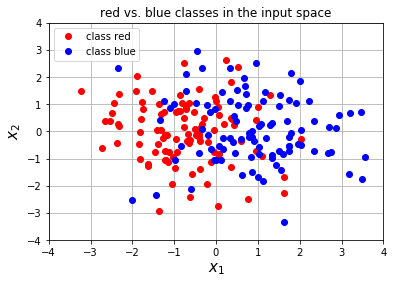

In [3]:

# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-4, 4, -4, 4])
plt.title('red vs. blue classes in the input space')
plt.show()

# Siec Neuronowa, a regresja logistyczna

Przypomnijmy sobie co robi regresja logistyczna. Z L7:

Przekształcając $$ \log(o) = \sum \theta_i x_i $$ otrzymujemy *bezpośrednio*, że $$ p(y | x) = \mbox{sigmoid}(\sum \theta_i x_i) $$, gdzie $sigmoid(a) = \frac{1}{1 + \exp(-a)}$.

Można ostatni wzór zapisać w postaci "sieci neuronowej":

<center><img width=500 src="figures/L9/logreg.png"></center>

To co pozostaje to jak wyznaczyć wagi przez optymalizacją. Przypomnijmy, że szukamy parametrów optymalizujących log-likelihood $$ LL(\hat y, y) = CE(\hat y, y) = \sum_{i=1}^{N} y \log\hat(y) $$. W regresji liniowej było prosto!

[Opisać/wyjaśnic cross entropy]

## Czego szuka regresja logistyczna

Regresja logistyczna dostaje kare za najdrobniejsza pomyłkę. Jeśli dla kasy 1 mówi z pewnością 99%, to dalej będzie niezerowy koszt:
    
<img width=500 src="figures/L9/logreg_vs_svm.png">

## Optymalizacja

Jak dotad nie rozpatrywaliśmy optymalizacji. Regresja liniowa ma rozwiązanie "zamknięte", ale nie wiemy jak optymalizować błąd regresji logistycznej!

$$ \theta^* = argmax_{\theta} L(p( \hat y | x, \theta), y) = CE(p(\hat y | x, \theta), y) = \sum_{i=1}^{N} y \log\hat(y) $$.

Dla klas binarnych:

$$ \sum_{i=1}^N y_i \log \hat y_i - (1 - y_i) \log (1 - \hat y_i ) $$

Jak znaleźć $\theta^*$? Użyjemy metody gradientowej:

$$ \theta^{t+1} = \theta^{t} - \alpha \frac{\partial L}{\partial \theta} $$

### Funkcja kosztu nie jest już taka prosta!

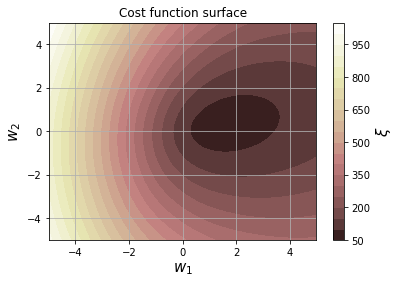

In [9]:
# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 100 # compute the cost nb_of_ws times in each dimension
ws1 = np.linspace(-5, 5, num=nb_of_ws) # weight 1
ws2 = np.linspace(-5, 5, num=nb_of_ws) # weight 2
ws_x, ws_y = np.meshgrid(ws1, ws2) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix

# Fill the cost matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = cost(nn(toy_train, np.asmatrix([ws_x[i,j], ws_y[i,j]])) , toy_y_train)
        
# Plot the cost function surface
plt.contourf(ws_x, ws_y, cost_ws, 20, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$\\xi$', fontsize=15)
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Cost function surface')
plt.grid()
plt.show()

### Implementacja SGD

[Wyprowadzić na tablicy wzór na dLL/dtheta_i, jak to sie ma do backprop]

Jak właśnie pokazaliśmy $$ \frac{\partial L}{\partial \theta_i} = x_i (\hat y_i - t_i) $$

[Interpretacja geometryczna gradientu regresji logistycznej]

### Zadanie 1, Nauka regresji logistycznej przez GD [2pkt]

(Uwaga: jest GD nie SGD ponieważ liczymy gradient na całym zbiorze)

1. Zaimplementuj GD dla zbioru danych toy. 
2. Wygeneruj wizualizacje procesu uczenia (ostatnia komórka)
3. Narysuj wizualizacje dla learning_rate=10.0, 5.0, 2.5, 1.0
4. Dla jakiego learning_rate osiągamy najlepszą dokladnosc na (toy_test, toy_y_test)?

Co powinno wyjść dla odpowiednio 5.0 oraz 2.5

<img width=200 src="figures/L9/lr5.png">
<img width=200 src="figures/L9/lr2.5.png">

Uwaga: Należy uśredniać gradient w funkcji "gradient", dziękujemy za zauważenie błędu Krzysztofowi Paskowi.

In [29]:
def gradient(w, x, t): 
    return (nn(x, w) - t).T * x

        


In [39]:
def gradient(w, x, t): 
    return (nn(x, w) - t).T * x

def delta_w(w_k, x_train, target, learning_rate):
    A=np.array([gradient(w_k,x_train[i],target[i]) for i in range(len(x_train))])
    grad=np.array([[0,0]])
    for i in range(len(x_train)):
        grad=grad+A[i]
    dw=grad*(learning_rate/len(x_train))
    return dw
# Parametry uczenia 
w = np.asmatrix([-4, -2])
learning_rate = 5.0

# Uczenie
nb_of_iterations = 10 
w_iter = [w] 
for i in range(nb_of_iterations):
    dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
    print dw
    w = w - dw 
    w_iter.append(w)  

[[-4.73281183 -0.58056303]]
[[-0.78014947 -1.51714825]]
[[ 0.03892866 -0.17590523]]
[[-0.00741362  0.00110938]]
[[-0.00281804 -0.00126726]]
[[-0.00137349 -0.00051339]]
[[-0.00065321 -0.0002486 ]]
[[-0.00031184 -0.00011843]]
[[ -1.48921270e-04  -5.65582557e-05]]
[[ -7.11402641e-05  -2.70155032e-05]]


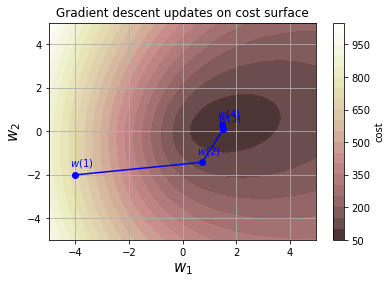

In [40]:
# Plot the first weight updates on the error surface
# Plot the error surface
plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('cost')

# Plot the updates
for i in range(1, 4): 
    w1 = w_iter[i-1]
    w2 = w_iter[i]
    # Plot the weight-cost value and the line that represents the update
    plt.plot(w1[0,0], w1[0,1], 'bo')  # Plot the weight cost value
    plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], 'b-')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(i), color='b')
w1 = w_iter[3]  
# Plot the last weight
plt.plot(w1[0,0], w1[0,1], 'bo')
plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(4), color='b') 
# Show figure
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

In [42]:
w = np.asmatrix([-4, -2])
learning_rate = 2.5

# Uczenie
nb_of_iterations = 10 
w_iter = [w] 
for i in range(nb_of_iterations):
    dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
    #print dw
    w = w - dw 
    w_iter.append(w)  

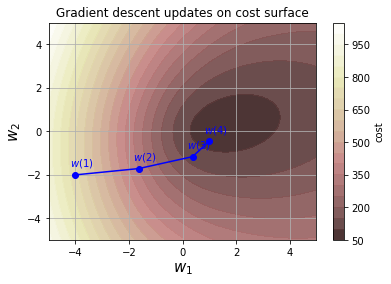

In [43]:
# Plot the first weight updates on the error surface
# Plot the error surface
plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('cost')

# Plot the updates
for i in range(1, 4): 
    w1 = w_iter[i-1]
    w2 = w_iter[i]
    # Plot the weight-cost value and the line that represents the update
    plt.plot(w1[0,0], w1[0,1], 'bo')  # Plot the weight cost value
    plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], 'b-')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(i), color='b')
w1 = w_iter[3]  
# Plot the last weight
plt.plot(w1[0,0], w1[0,1], 'bo')
plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(4), color='b') 
# Show figure
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

In [ ]:
w = np.asmatrix([-4, -2])
learning_rate = 10.

# Uczenie
nb_of_iterations = 10 
w_iter = [w] 
for i in range(nb_of_iterations):
    dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
    #print dw
    w = w - dw 
    w_iter.append(w)

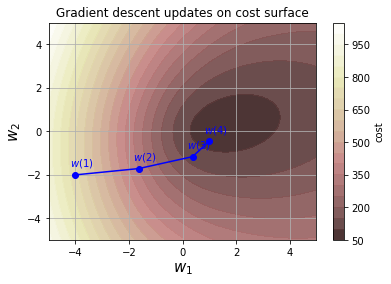

In [44]:
# Plot the first weight updates on the error surface
# Plot the error surface
plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('cost')

# Plot the updates
for i in range(1, 4): 
    w1 = w_iter[i-1]
    w2 = w_iter[i]
    # Plot the weight-cost value and the line that represents the update
    plt.plot(w1[0,0], w1[0,1], 'bo')  # Plot the weight cost value
    plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], 'b-')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(i), color='b')
w1 = w_iter[3]  
# Plot the last weight
plt.plot(w1[0,0], w1[0,1], 'bo')
plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(4), color='b') 
# Show figure
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

In [45]:
w = np.asmatrix([-4, -2])
learning_rate = 1.

# Uczenie
nb_of_iterations = 10 
w_iter = [w] 
for i in range(nb_of_iterations):
    dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
    #print dw
    w = w - dw 
    w_iter.append(w)

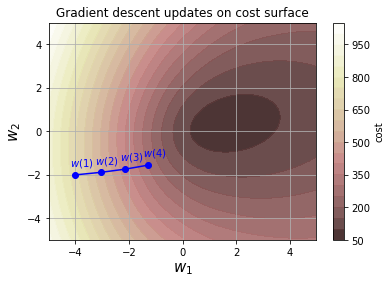

In [46]:
# Plot the first weight updates on the error surface
# Plot the error surface
plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('cost')

# Plot the updates
for i in range(1, 4): 
    w1 = w_iter[i-1]
    w2 = w_iter[i]
    # Plot the weight-cost value and the line that represents the update
    plt.plot(w1[0,0], w1[0,1], 'bo')  # Plot the weight cost value
    plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], 'b-')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(i), color='b')
w1 = w_iter[3]  
# Plot the last weight
plt.plot(w1[0,0], w1[0,1], 'bo')
plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(4), color='b') 
# Show figure
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

In [54]:
def wagi(learning_rate):
    w = np.asmatrix([-4, -2])
    # Uczenie
    nb_of_iterations = 10 
    w_iter = [w] 
    for i in range(nb_of_iterations):
        dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
        #print dw
        w = w - dw 
        w_iter.append(w)
    return w

In [ ]:
I=np.linspace(0.1,10,50)
W=[wagi(x) for x in I]
Errors=[0 for x in I]
toy_train, toy_test, toy_y_train, toy_y_test = train_test_split(X_toy, t_toy, test_size=0.15)

In [75]:
toy_test[3]

array([-2.37102184, -0.41921127])

In [99]:
P=np.array([nn_predict(w1,toy_test[i]) for i in range(len(toy_test))])
P

(30L, 1L, 1L)

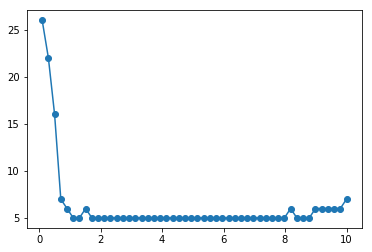

In [112]:
Errors=[]
for w in W:
    X=np.array([(nn_predict(w,toy_test[i]).item()-toy_y_test[i].item()) for i in range(len(toy_test))])
    X=np.array([x*x for x in X]) #by dobrze zliczać liczbę błędów
    Errors.append(X.sum())

plt.plot(I, Errors, 'o-', label='liniowa')  
#Wykres liczby błędów w przypadku zliczania błednych predykcji
#Oś Ox reprezentuje stałą uczenia
#OS Oy reprezentuje liczbę błędów

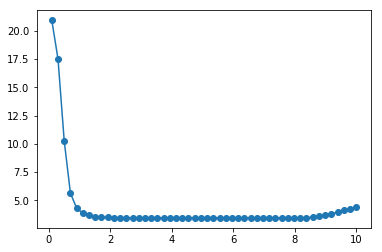

In [113]:
Errors=[]
for w in W:
    X=np.array([(nn(w,toy_test[i]).item()-toy_y_test[i].item()) for i in range(len(toy_test))])
    X=np.array([x*x for x in X]) #by dobrze zliczać liczbę błędów
    Errors.append(X.sum())

plt.plot(I, Errors, 'o-', label='liniowa')  
#Wykres wartości sumy kwadratów wartości funkci sigmoidalnej po wszyskich predykcjach
#Oś Ox reprezentuje stałą uczenia
#OS Oy reprezentuje liczbę błędów

# keras

Sieci neuronowe definiujemy prawie tak prosto jak funkcje w Pythonie, a pochodne (to co liczyłem na tablicy) powinien nam liczyć komputer!

In [7]:
dims = toy_train.shape[1]
print(dims, 'dims')
nb_classes = toy_y_train_one_hot.shape[1]
print(nb_classes, 'classes')

(2L, 'dims')
(2L, 'classes')


In [47]:
# 1. Definicja modelu
model = Sequential()
model.add(Dense(1000, input_shape=(dims, )))
model.add(Dense(nb_classes, input_shape=(1000,)))
model.add(Activation('softmax'))

# 2. Kompilacja
model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy')

# 3. Uczenie
model.fit(toy_train, toy_y_train_one_hot, epochs=10)

# 4. Predykcja
toy_y_pred = model.predict(toy_test).argmax(axis=1)
toy_y_train_pred = model.predict(toy_train).argmax(axis=1)
print model.layers[0].trainable_weights[0].get_value()
print np.mean(toy_y_train.reshape(-1,) == toy_y_train_pred)
print np.mean(toy_y_test.reshape(-1,) == toy_y_pred)

Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 0.6879 - 0s - loss: 0.5284     
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.4500 - 0s - loss: 0.4650     
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.2740 - 0s - loss: 0.4623     
Epoch 4/10
170/170 [==============================] - ETA: 0s - loss: 0.5048 - 0s - loss: 0.4646     
Epoch 5/10
170/170 [==============================] - ETA: 0s - loss: 0.4145 - 0s - loss: 0.4652     
Epoch 6/10
170/170 [==============================] - ETA: 0s - loss: 0.4538 - 0s - loss: 0.4590    

In [52]:
toy_train1=toy_train[0:30]
toy_y_train1=toy_y_train[0:30]
toy_y_train_one_hot1 = keras.utils.to_categorical(toy_y_train1)


In [48]:
toy_train, toy_test, toy_y_train, toy_y_test = train_test_split(X_toy, t_toy, test_size=0.15)

# Przyda sie do sekcji o kerasie
toy_y_train_one_hot = keras.utils.to_categorical(toy_y_train)
toy_y_test_one_hot = keras.utils.to_categorical(toy_y_test)

In [83]:
#Model z accuracy>95% dla small mnist
# 1. Definicja modelu
model = Sequential()
model.add(Dense(1000, input_shape=(dims, )))
model.add(Activation('relu'))
model.add(Dense(500, input_shape=(1000,)))
model.add(Activation('relu'))
model.add(Dense(2,input_shape=(500, )))

model.add(Activation('softmax'))
# 2. Kompilacja
model.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy')

# 3. Uczenie
model.fit(toy_train1, toy_y_train_one_hot1, epochs=1000)
##
toy_y_train_pred1 = model.predict(toy_train1).argmax(axis=1)

print np.mean(toy_y_train1.reshape(-1,) == toy_y_train_pred1)

Epoch 1/1000
30/30 [==============================] - 0s - loss: 0.7295
Epoch 2/1000
30/30 [==============================] - 0s - loss: 0.5714
Epoch 3/1000
30/30 [==============================] - 0s - loss: 0.4974
Epoch 4/1000
30/30 [==============================] - 0s - loss: 0.4502
Epoch 5/1000
30/30 [==============================] - 0s - loss: 0.4174
Epoch 6/1000
30/30 [==============================] - 0s - loss: 0.3941
Epoch 7/1000
30/30 [==============================] - 0s - loss: 0.3771
Epoch 8/1000
30/30 [==============================] - 0s - loss: 0.3645
Epoch 9/1000
30/30 [==============================] - 0s - loss: 0.3549
Epoch 10/1000
30/30 [==============================] - 0s - loss: 0.3475
Epoch 11/1000
30/30 [==============================] - 0s - loss: 0.3417
Epoch 12/1000
30/30 [==============================] - 0s - loss: 0.3371
Epoch 13/1000
30/30 [==============================] - 0s - loss: 0.3333
Epoch 14/1000
30/30 [==============================] - 0s - 

In [96]:
# Small MNIST 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
sm_train = mnist_x_train[0:500].astype('float32') / 255.
sm_y_train = mnist_y_train[0:500]
sm_test = mnist_x_test[0:500].astype('float32') / 255.
sm_y_test = mnist_y_test[0:500]
sm_train = sm_train.reshape((len(sm_train), np.prod(sm_train.shape[1:])))
sm_test = sm_test.reshape((len(sm_test), np.prod(sm_test.shape[1:])))
print sm_train.shape
print sm_test.shape
 
sm_y_test_one_hot=keras.utils.to_categorical(sm_y_test)
sm_y_train_one_hot=keras.utils.to_categorical(sm_y_train)


(500L, 784L)
(500L, 784L)


In [95]:
print sm_y_test[0]
len(sm_y_test_one_hot[0])

7


10

In [133]:
model = Sequential()
model.add(Dense(150, input_shape=(784, )))
model.add(Dense(500, input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dense(10, input_shape=(300,)))
model.add(Activation('softmax'))
# 2. Kompilacja
model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy')

# 3. Uczenie
model.fit(sm_train, sm_y_train_one_hot, epochs=100)



Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 2.3310 - 0s - loss: 1.7583     
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 1.1845 - 0s - loss: 0.8653     
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.5698 - 0s - loss: 0.5545     
Epoch 4/100
500/500 [==============================] - ETA: 0s - loss: 0.4316 - 0s - loss: 0.4066     
Epoch 5/100
500/500 [==============================] - ETA: 0s - loss: 0.3615 - 0s - loss: 0.3305     
Epoch 6/100
500/500 [==============================] - ETA: 0s - loss: 0.3791 - 0s - loss: 0.26

In [139]:
sm_y_test_pred = model.predict(sm_test).argmax(axis=1)
sm_train_pred = model.predict(sm_train).argmax(axis=1)
#print np.mean(sm_train.reshape(-1,) == sm_train_pred)
print np.mean(sm_y_test.reshape(-1,) == sm_y_test_pred)

0.84


In [146]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
model = LogisticRegression(C=10)
model.fit(sm_train,sm_y_train)
pred = model.predict(sm_train)
print metrics.accuracy_score(pred, sm_y_test)

0.104


In [ ]:
#Sieć neurownowa poradziła sobie dużo lepiej

In [ ]:
# Small MNIST 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
sm_train = mnist_x_train[0:500].astype('float32') / 255.
sm_y_train = mnist_y_train[0:500]
sm_test = mnist_x_test[0:500].astype('float32') / 255.
sm_y_test = mnist_y_test[0:500]
sm_train = sm_train.reshape((len(sm_train), np.prod(sm_train.shape[1:])))
sm_test = sm_test.reshape((len(sm_test), np.prod(sm_test.shape[1:])))
print sm_train.shape
print sm_test.shape
 
sm_y_test_one_hot=keras.utils.to_categorical(sm_y_test)
sm_y_train_one_hot=keras.utils.to_categorical(sm_y_train)


In [129]:
sm_y_test_pred = model.predict(sm_test)
sm_train_pred = model.predict(sm_train)

In [135]:
sm_y_test_pred = model.predict(sm_test).argmax(axis=1)
sm_train_pred = model.predict(sm_train).argmax(axis=1)

## Zadanie 2, Proste modyfikacje [2pkt]


1. (1pkt) Zmodyfikuj powyższą sieć tak aby osiągnęła min. 95% na zmniejszonym do 30 przykładów zbiorze trenującym w rozważanym datasecie. Odpowiedz na pytania:
   * Czy ten model osiąga lepszy wynik na zbiorze testowym niż regresja logistyczna?
   * Czy można osiągnąć lepszy wynik na tym zbiorze danych, nawet jeśli posiadalibyśmy nieskończoną próbkę danych?
2. (1pkt) Naucz 2 warstwową sieć na smallMNIST. Czy dla jakiegoś rozmiaru ukrytej warstwy osiąga lepszy wynik niż regresja logistyczna

# Inne sieci neuronowe

Najprostsze co możemy zrobić to dodać warstwy. Po co omówimy w następnym rozdziale.

<img width=600 src="figures/L9/zoo.jpg">

# Znaczenie reprezentacji, kNN

Najproszym argumentem po co te sieci jest możliwość uczenia się lepszych reprezentacji niż pixele, czy ręczne cechy w zbiorze danych breast cancer. Omówimy to na przykładzie zbiorów danych: iris i MNIST oraz klasyczngo modelu kNN.

Uruchomimy najpierw model kNN na danych iris

<img width=600 src="https://sebastianraschka.com/images/blog/2015/principal_component_analysis_files/iris.png">

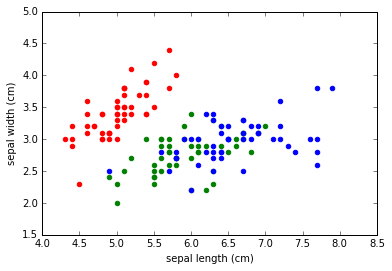

In [34]:
plt.scatter(iris.data[iris['target']==0, 0], iris.data[iris['target']==0, 1], color='r')
plt.scatter(iris.data[iris['target']==1, 0], iris.data[iris['target']==1, 1], color='g')
plt.scatter(iris.data[iris['target']==2, 0], iris.data[iris['target']==2, 1], color='b')
plt.xlabel(iris['feature_names'][0])
plt.ylabel(iris['feature_names'][1])

In [40]:
def knn_pred(x, x_train, y_train):
    current_best = -1, 100000
    for id in range(len(x_train)):
        dist = np.linalg.norm(x - x_train[id])
        if dist < current_best[1]:
            current_best = (id, dist)
    return y_train[current_best[0]]

## kNN na Iris

In [38]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.15)

In [39]:
Y_test_pred = []
for x in tqdm.tqdm(X_test, total=len(X_test)):
    Y_test_pred.append(knn_pred(x, x_train=X_train))
print str(int(100*np.mean(np.array(Y_test_pred) == y_test))),"%"

95 %


## small MNIST

Na Iris nasz prosty model osiąga 91%. Co sie dzieje na small MNIST?

In [41]:
Y_test_pred = []
for x in tqdm.tqdm(sm_test, total=len(sm_test)):
    Y_test_pred.append(knn_pred(x, x_train=sm_train, y_train=sm_y_train))
print str(int(100*np.mean(np.array(Y_test_pred) == sm_y_test))),"%"

67 %


## Co sie stalo

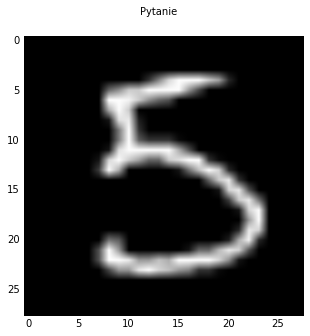

In [42]:
id_test = 15
plt.figure(figsize=(5, 5))
plt.suptitle("Pytanie")
plt.imshow(x_test[id_test].reshape(28, 28), cmap=plt.cm.gray)

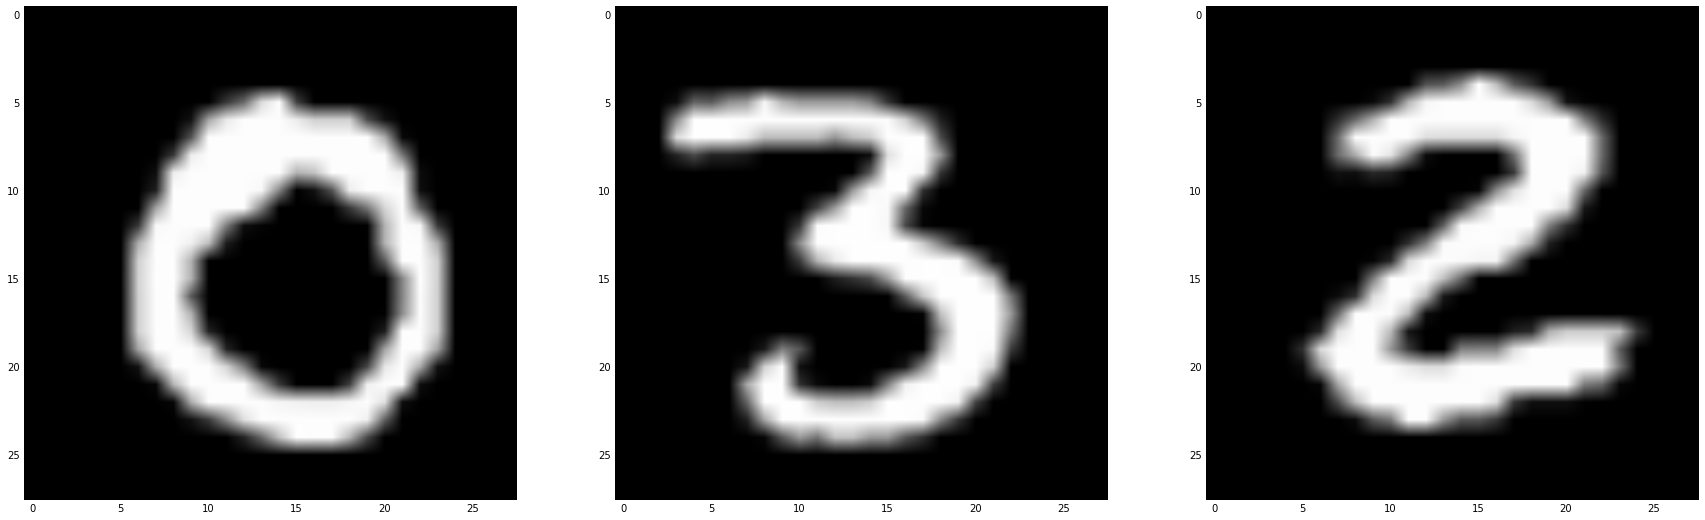

In [49]:
all_dists = [np.linalg.norm(x_test[id_test].reshape(-1,) - x) for x in sm_train]
all_dists = np.argsort(all_dists)

f, ax = plt.subplots(1, 3, figsize=(30, 10))

for id, i in enumerate(all_dists[0:3]):
    ax[id].imshow(sm_train[all_dists[id]].reshape(28, 28), cmap=plt.cm.gray)

## Nauka reprezentacji

Ref: http://colah.github.io/posts/2014-10-Visualizing-MNIST/

Czlowiek uczy się reprezentacji - widzimy na poziomie krawędzi i kształtów, a nie pixeli!

<img width=500 src="figures/L9/cat_experiment_no_reference.png">

Zastanówmy się wspólnie jaka reprezentacja byłaby fajna? Główna idea Representation Learning, może będzie o tym więcej wkrótce:

<img width=600 src="figures/L9/autoencoder_schema.jpg">

### PCA

Na obecną chwilę użyjemy PCA, o którym prawdopodobnie będzie dużo więcej w przyszłości. 

<img src="figures/L9/pca.png">

(ilustracja pochodzi z tutorialu na temat PCA oraz ICA w sklearn, http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html#sphx-glr-auto-examples-decomposition-plot-ica-vs-pca-py)

In [162]:
mnist_x_trainSub=np.array([mnist_x_train[i] for i in range(len(mnist_x_train)) if mnist_y_train[i]<5])
mnist_y_trainSub=np.array([mnist_y_train[i] for i in range(len(mnist_x_train)) if mnist_y_train[i]<5])
print len(mnist_y_trainSub) ,len(mnist_x_trainSub)


30596 30596


C:\Users\kuba\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[]

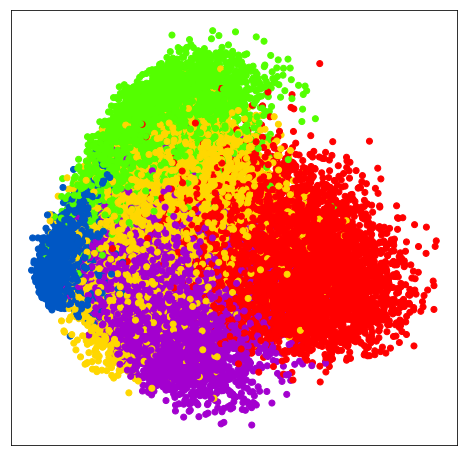

In [164]:
pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()

X_transformed = pca.fit_transform(mnist_x_trainSub.reshape(mnist_x_trainSub.shape[0], -1))
plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=mnist_y_trainSub)
plot.set_xticks(())
plot.set_yticks(())

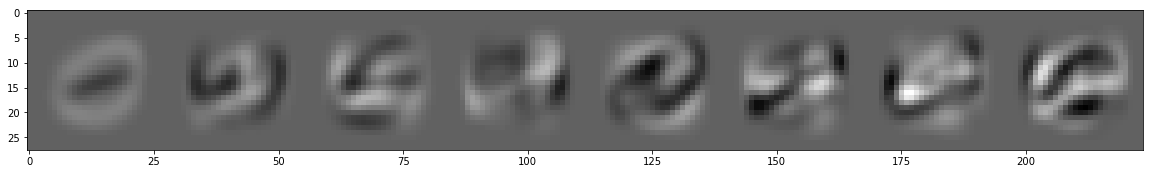

In [165]:
plt.figure(figsize=(20, 8 * 20))
plt.imshow(pca.components_.reshape((8 * 28, 28)).T, cmap="gray")

C:\Users\kuba\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[]

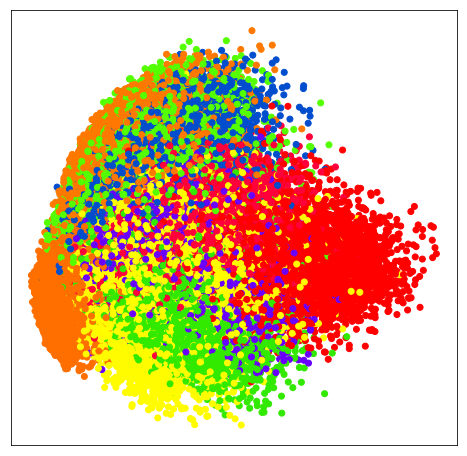

In [147]:
pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()

X_transformed = pca.fit_transform(mnist_x_train.reshape(mnist_x_train.shape[0], -1))
plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=mnist_y_train)
plot.set_xticks(())
plot.set_yticks(())

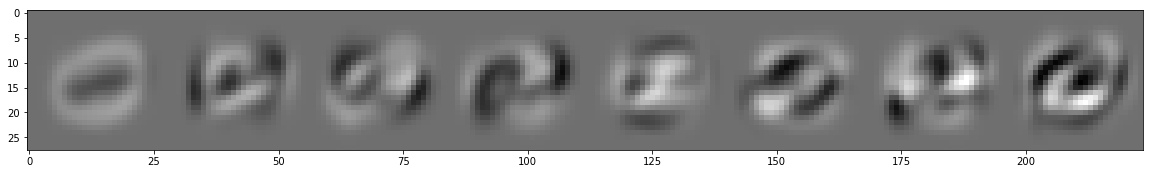

In [148]:
plt.figure(figsize=(20, 8 * 20))
plt.imshow(pca.components_.reshape((8 * 28, 28)).T, cmap="gray")

W przypadku twarzy PCA znajdzie bardzo ciekawy zestaw "cech", czy "wektorów bazowych":

<img width=400 src="figures/L9/eigenfaces.png">

## Zadanie 3, czy cechy pomagają w kNN [1pkt]

1. Naucz PCA jedynie na cyfrach 5 i załącz analogiczny plot jak powyżej

2. Użyj nauczonych cech (na całym zbiorze mnist) przez PCA do klasyfikacji kNN na zbiorze small MNIST. Jaki można osiągnąć wynik? Użyj KNeighborsClassifier z pakietu sklearn. Dopasuj parametry PCA oraz tak KNeighborsClassifier aby osiągnąć najlepszy wynik na zbiorze sm_test, wymagany jest wynik powyżej 80% na zbiorze testowym.

In [166]:
mnist_x_trainSub=np.array([mnist_x_train[i] for i in range(len(mnist_x_train)) if mnist_y_train[i]<5])
mnist_y_trainSub=np.array([mnist_y_train[i] for i in range(len(mnist_x_train)) if mnist_y_train[i]<5])
print len(mnist_y_trainSub) ,len(mnist_x_trainSub)

30596 30596


C:\Users\kuba\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[]

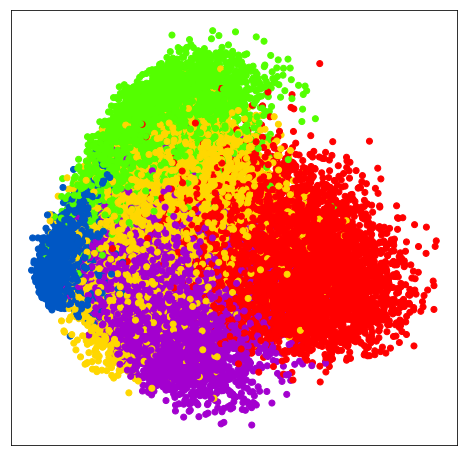

In [168]:
pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()

X_transformed = pca.fit_transform(mnist_x_trainSub.reshape(mnist_x_trainSub.shape[0], -1))
plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=mnist_y_trainSub)
plot.set_xticks(())
plot.set_yticks(())

In [ ]:
# Small MNIST 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
sm_train = mnist_x_train[0:500].astype('float32') / 255.
sm_y_train = mnist_y_train[0:500]
sm_test = mnist_x_test[0:500].astype('float32') / 255.
sm_y_test = mnist_y_test[0:500]
sm_train = sm_train.reshape((len(sm_train), np.prod(sm_train.shape[1:])))
sm_test = sm_test.reshape((len(sm_test), np.prod(sm_test.shape[1:])))
print sm_train.shape
print sm_test.shape


In [179]:
from sklearn.neighbors import KNeighborsClassifier

In [213]:
#Nie udało mi się trafić na żadną transformacja i ilość sąsiadów, która nie działała by w sposób głupi taki jak poniżej
pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)


X_transformed = pca.fit_transform(mnist_x_train.reshape(mnist_x_train.shape[0], -1))
sm_test_tranform=pca.transform(sm_test)
model = KNeighborsClassifier(n_neighbors=100)
model.fit(X_transformed,mnist_y_train)
model.predict(sm_test_tranform)


C:\Users\kuba\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5,